In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
tf.random.set_seed(13)

## Reading data

In [2]:
# reading data
evo_data = pd.read_csv('data/demand_datasets/evo_demand.csv', index_col=0)
modo_data = pd.read_csv('data/demand_datasets/modo_demand.csv', index_col=0)
c2g_data = pd.read_csv('data/demand_datasets/c2g_demand.csv', index_col=0)

In [3]:
init_period = '06-23'
end_period = '07-12'

evo_data = evo_data[(evo_data.index >= '2018-'+init_period) & (evo_data.index <= '2018-'+end_period)]
modo_data = modo_data[(modo_data.index >= '2018-'+init_period) & (modo_data.index <= '2018-'+end_period)]
c2g_data = c2g_data[(c2g_data.index >= '2017-'+init_period) & (c2g_data.index <= '2017-'+end_period)]

In [6]:
def train_size(data, size=0.7):
    # 70% of the data to use as train set
    train_split = int(len(data) * size)
    return train_split

In [7]:
def norm_data(features, train_split):
    dataset = features.values
    data_max = dataset[:train_split].max()
    data_min = dataset[:train_split].min()
    data_std = dataset[:train_split].std(axis=0)

    dataset = (dataset-data_min)/(data_max - data_min)
    
    return dataset

In [8]:
modo_norm = norm_data(modo_data, train_size(modo_data))
evo_norm = norm_data(evo_data, train_size(evo_data))
c2g_norm = norm_data(c2g_data, train_size(c2g_data))

## LSTM Data preparation

For this analysis the aim is to predict the number of travels using a multivariate LSTM model

In [9]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    """
    Reshape the data to usual representation of train and target sets
    
    single_step - In a single step setup (True), the model learns to predict a single point in the future 
                  based on some history provided. Else (False), the model needs to learn to predict a range 
                  of future values.
    
    target_size - Is how far in the future does the model need to learn to predict.
                  The target_size is from the label that needs to be predicted
    """
    data = []
    labels = []

    start_index = start_index + history_size # determining the real start since it has a history size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index): # creating the data 'chuncks' with size of history size
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step: # selecting the point or interval to be predicted
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [10]:
def train_val_split(data, train_split, history_length=72, future_target=1, 
                    step=1, single_step=False, batch_size=256, buffer_size=10000):

    # splitting the train and evaluate sets
    x_train, y_train = multivariate_data(data, data[:, 0], 0, train_split, history_length, future_target, step, single_step)
    x_val, y_val = multivariate_data(data, data[:, 0], train_split, None, history_length, future_target, step, single_step)

    print ('\nSingle window of past history : {}'.format(x_train[0].shape))
    print ('Target feature to predict : {}'.format(y_train[0].shape))
    
    # slice and shuffle the train and evaluate sets based on the batch size
    train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train = train.cache().shuffle(buffer_size).batch(batch_size).repeat()

    val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val = val.batch(batch_size).repeat()
    
    shape = x_train.shape[-2:]
    
    return train, val, shape

In [11]:
def lstm_model(train_data, validation_data, shape, epochs=10, evaluation_interval=200):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(75, return_sequences=True,
                                  input_shape=shape))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(43, activation='relu'))
    model.add(tf.keras.layers.Dense(12))
    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), 
                  loss='mae', metrics=['mse','mae'])
    
    for x, y in validation_data.take(1):
        print(model.predict(x).shape)
    
    history = model.fit(train_data, epochs=epochs,
                      steps_per_epoch=evaluation_interval,
                      validation_data=validation_data,
                      validation_steps=50)
    
    return model, history

In [12]:
# split data on train and validate sets
evo_train, evo_val, evo_shape = train_val_split(data=evo_norm, train_split=train_size(evo_norm), history_length=24, future_target=12)
modo_train, modo_val, modo_shape = train_val_split(data=modo_norm, train_split=train_size(modo_norm), history_length=24, future_target=12)
c2g_train, c2g_val, c2g_shape = train_val_split(data=c2g_norm, train_split=train_size(c2g_norm), history_length=24, future_target=12)


Single window of past history : (24, 75)
Target feature to predict : (12,)

Single window of past history : (24, 75)
Target feature to predict : (12,)

Single window of past history : (24, 75)
Target feature to predict : (12,)


# Training Models

In [13]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = range(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(len(history),num_out+len(history)), np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(len(history),num_out+len(history)), np.array(prediction), 'rX-',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [14]:
def plot_train_history(history, title):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)

    plt.show()

Next, will be generated the model for each dataset

## Evo Model

In [15]:
print('Evo Model')
evo_model, evo_history = lstm_model(evo_train, evo_val, evo_shape, epochs=20)

Evo Model
(43, 12)
Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 28s 139ms/step - loss: 0.1236 - mse: 0.0326 - mae: 0.1236 - val_loss: 0.1162 - val_mse: 0.0268 - val_mae: 0.1162
Epoch 2/20
200/200 [==============================] - 20s 101ms/step - loss: 0.0869 - mse: 0.0217 - mae: 0.0869 - val_loss: 0.1079 - val_mse: 0.0248 - val_mae: 0.1079
Epoch 3/20
200/200 [==============================] - 23s 116ms/step - loss: 0.0753 - mse: 0.0183 - mae: 0.0753 - val_loss: 0.1012 - val_mse: 0.0220 - val_mae: 0.1012
Epoch 4/20
200/200 [==============================] - 21s 107ms/step - loss: 0.0664 - mse: 0.0157 - mae: 0.0664 - val_loss: 0.0885 - val_mse: 0.0196 - val_mae: 0.0885
Epoch 5/20
200/200 [==============================] - 22s 112ms/step - loss: 0.0603 - mse: 0.0141 - mae: 0.0603 - val_loss: 0.0862 - val_mse: 0.0196 - val_mae: 0.0862
Epoch 6/20
200/200 [==============================] - 22s 110ms/step - loss: 0.0555 - mse: 0.0128 - mae

### Plotting prediction

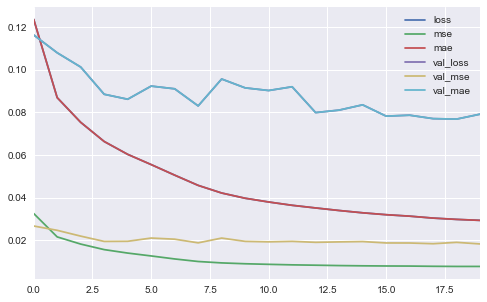

In [16]:
plot_train_history(evo_history,
                   'Training and validation loss')

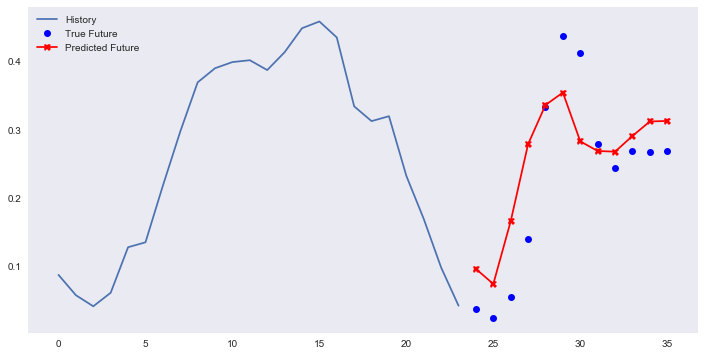

In [17]:
for x, y in evo_val.take(1):
    multi_step_plot(x[0], y[0], evo_model.predict(x)[0])

## Modo model

In [18]:
print('Modo Model')
modo_model, modo_history = lstm_model(modo_train, modo_val, modo_shape, epochs=20)

Modo Model
(83, 12)
Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 29s 147ms/step - loss: 0.0486 - mse: 0.0071 - mae: 0.0486 - val_loss: 0.0417 - val_mse: 0.0043 - val_mae: 0.0417
Epoch 2/20
200/200 [==============================] - 23s 115ms/step - loss: 0.0337 - mse: 0.0054 - mae: 0.0337 - val_loss: 0.0433 - val_mse: 0.0048 - val_mae: 0.0433
Epoch 3/20
200/200 [==============================] - 24s 119ms/step - loss: 0.0304 - mse: 0.0051 - mae: 0.0304 - val_loss: 0.0392 - val_mse: 0.0043 - val_mae: 0.0392
Epoch 4/20
200/200 [==============================] - 24s 119ms/step - loss: 0.0283 - mse: 0.0049 - mae: 0.0283 - val_loss: 0.0380 - val_mse: 0.0040 - val_mae: 0.0380
Epoch 5/20
200/200 [==============================] - 24s 121ms/step - loss: 0.0268 - mse: 0.0046 - mae: 0.0268 - val_loss: 0.0374 - val_mse: 0.0041 - val_mae: 0.0374
Epoch 6/20
200/200 [==============================] - 24s 119ms/step - loss: 0.0257 - mse: 0.0045 - ma

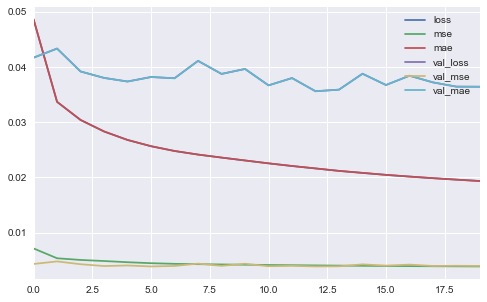

In [19]:
plot_train_history(modo_history,
                   'Training and validation loss')

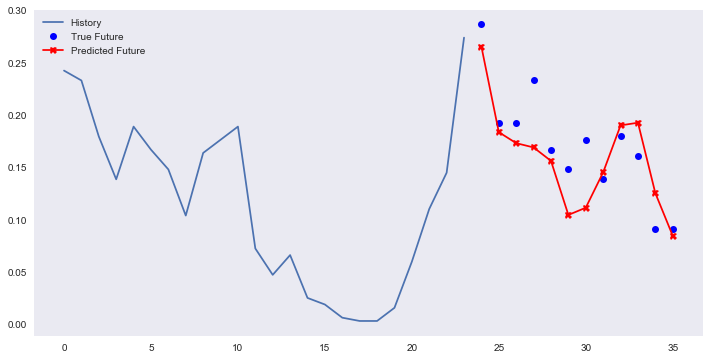

In [20]:
for x, y in modo_val.take(1):
    multi_step_plot(x[0], y[0], modo_model.predict(x)[0])

## Car2Go Model

In [22]:
print('Car2Go Model')
c2g_model, c2g_history = lstm_model(c2g_train, c2g_val, c2g_shape, epochs=20)

Car2Go Model
(96, 12)
Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 24s 121ms/step - loss: 0.1636 - mse: 0.0463 - mae: 0.1641 - val_loss: 0.1133 - val_mse: 0.0211 - val_mae: 0.1133
Epoch 2/20
200/200 [==============================] - 17s 85ms/step - loss: 0.1141 - mse: 0.0264 - mae: 0.1148 - val_loss: 0.1064 - val_mse: 0.0184 - val_mae: 0.1064
Epoch 3/20
200/200 [==============================] - 17s 85ms/step - loss: 0.1047 - mse: 0.0240 - mae: 0.1067 - val_loss: 0.0945 - val_mse: 0.0151 - val_mae: 0.0945
Epoch 4/20
200/200 [==============================] - 18s 89ms/step - loss: 0.0991 - mse: 0.0220 - mae: 0.1005 - val_loss: 0.0825 - val_mse: 0.0113 - val_mae: 0.0825
Epoch 5/20
200/200 [==============================] - 18s 90ms/step - loss: 0.0942 - mse: 0.0202 - mae: 0.0946 - val_loss: 0.0884 - val_mse: 0.0121 - val_mae: 0.0884
Epoch 6/20
200/200 [==============================] - 18s 90ms/step - loss: 0.0873 - mse: 0.0188 - mae: 

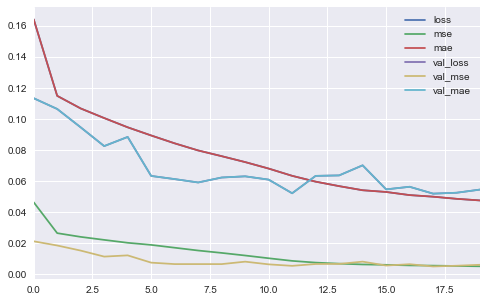

In [23]:
plot_train_history(c2g_history,
                   'Training and validation loss')

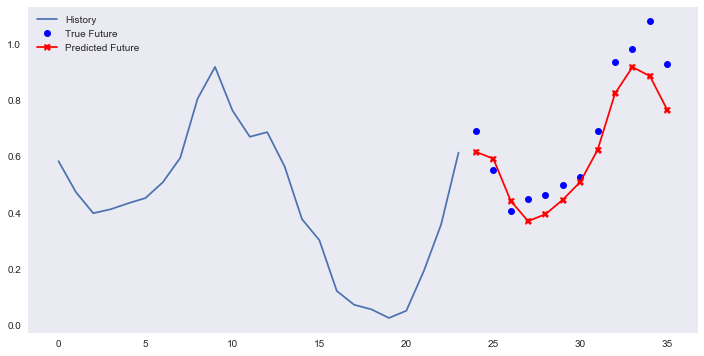

In [24]:
for x, y in c2g_val.take(1):
    multi_step_plot(x[0], y[0],c2g_model.predict(x)[0])

### References

* https://www.tensorflow.org/tutorials/structured_data/time_series#part_2_forecast_a_multivariate_time_series
* http://netlab.ice.ufjf.br/index.php/carsharingdata/